In [12]:
!yes | conda install numpy matplotlib; yes | conda install -c pytorch pytorch torchvision

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: pytorch arxiv
yes: stdout: Broken pipe


In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # step1 データの作成

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using {device}")

Using mps


Create smaple data

In [235]:
N = 100
x_data = np.zeros((N,2))
y_data = np.zeros((N,1))

np.random.seed(42)

for i in range(N):
    r = np.random.uniform(0,2)
    th = np.random.uniform(0,2*np.pi)
    x_data[i] = r*np.cos(th), r*np.sin(th)
    if r > 1:
        y_data[i] = 1

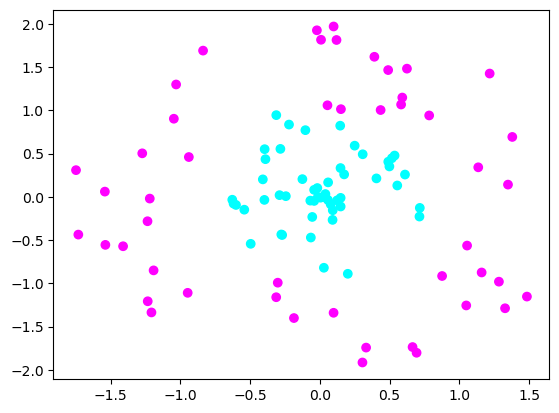

In [236]:
plt.scatter(x_data[:,0],x_data[:,1],c=y_data,cmap="cool")

In [237]:
# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x_data)
y_tensor = torch.tensor(y_data)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

# Create a DataLoader from the TensorDataset
N_batch = 5
dataloader = DataLoader(dataset, batch_size=N_batch, shuffle=True)

Build models

In [238]:
class NeuralNetwork(nn.Module):
    def __init__(self,width,depth):
        super(NeuralNetwork, self).__init__()
        self.depth = depth
        self.activation = nn.ReLU()
        # first hidden layer
        self.dense1 = nn.Linear(2,width,False).double() # 2 * width weights
        # deep layer
        self.seq = nn.Linear(width,width,False).double() # width * width weights
        # output layer for binary logistic regression
        self.blr = nn.Sequential(
            nn.Linear(width,1,False).double(), # width weights
            nn.Sigmoid()
        )

    def forward(self, x):
        l = self.depth
        for i in range(l):
            if i == 0:
                x = self.dense1(x)
                x = self.activation(x)
            else:
                x = self.seq(x)
                x = self.activation(x)
        return self.blr(x)

Check that relevant parameters are only updated.

In [ ]:
model = NeuralNetwork(width=2,depth=1)
for name, param in model.named_parameters():
    print(f'{name}: {param}')

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters())
model.train(True)
last_loss = 0
for i, data in enumerate(dataloader): # N//N_batch loops 
    inputs, labels = data
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    last_loss += loss.item() / (N//N_batch)

for name, param in model.named_parameters():
    print(f'{name}: {param}')


In [241]:
models=dict()
models["base"] = NeuralNetwork(width=4,depth=1)

models["2 hidden"] = NeuralNetwork(width=4, depth=2)
models["3 hidden"] = NeuralNetwork(width=4, depth=3)
models["4 hidden"] = NeuralNetwork(width=4, depth=4)

models["width16"] = NeuralNetwork(width=16,depth=1)
models["width64"] = NeuralNetwork(width=64,depth=1)
models["width256"] = NeuralNetwork(width=256,depth=1)

loss_fn = nn.BCELoss()

# debug
# loss_fn(models["base"](torch.rand(1,2)), torch.tensor([0]))

In [243]:
N_epoch = 10000

for key, model in models.items():
    for epoch in range(N_epoch):
        optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)
        model.train(True)
        last_loss = 0
        for i, data in enumerate(dataloader): # N//N_batch loops 
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            last_loss += loss.item() / (N//N_batch)
        # verbose
        print(f"{key} epoch {epoch+1} finised. loss: {last_loss}")

base epoch 1 finised. loss: 0.5828175259499773
base epoch 2 finised. loss: 0.5831422778929376
base epoch 3 finised. loss: 0.5835148522535515
base epoch 4 finised. loss: 0.5831727208282497
base epoch 5 finised. loss: 0.5831132498036526
base epoch 6 finised. loss: 0.5828523566940764
base epoch 7 finised. loss: 0.583157552988776
base epoch 8 finised. loss: 0.5833021309955404
base epoch 9 finised. loss: 0.5831565953681808
base epoch 10 finised. loss: 0.583182073753432
base epoch 11 finised. loss: 0.5830884461909887
base epoch 12 finised. loss: 0.5831035529058598
base epoch 13 finised. loss: 0.5831247332757196
base epoch 14 finised. loss: 0.5834562302972881
base epoch 15 finised. loss: 0.582893804295269
base epoch 16 finised. loss: 0.5836844121298663
base epoch 17 finised. loss: 0.5827858876554987
base epoch 18 finised. loss: 0.5824514156271875
base epoch 19 finised. loss: 0.5836401328223192
base epoch 20 finised. loss: 0.5832601728734872
base epoch 21 finised. loss: 0.5829969598699989
base

Visualize

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

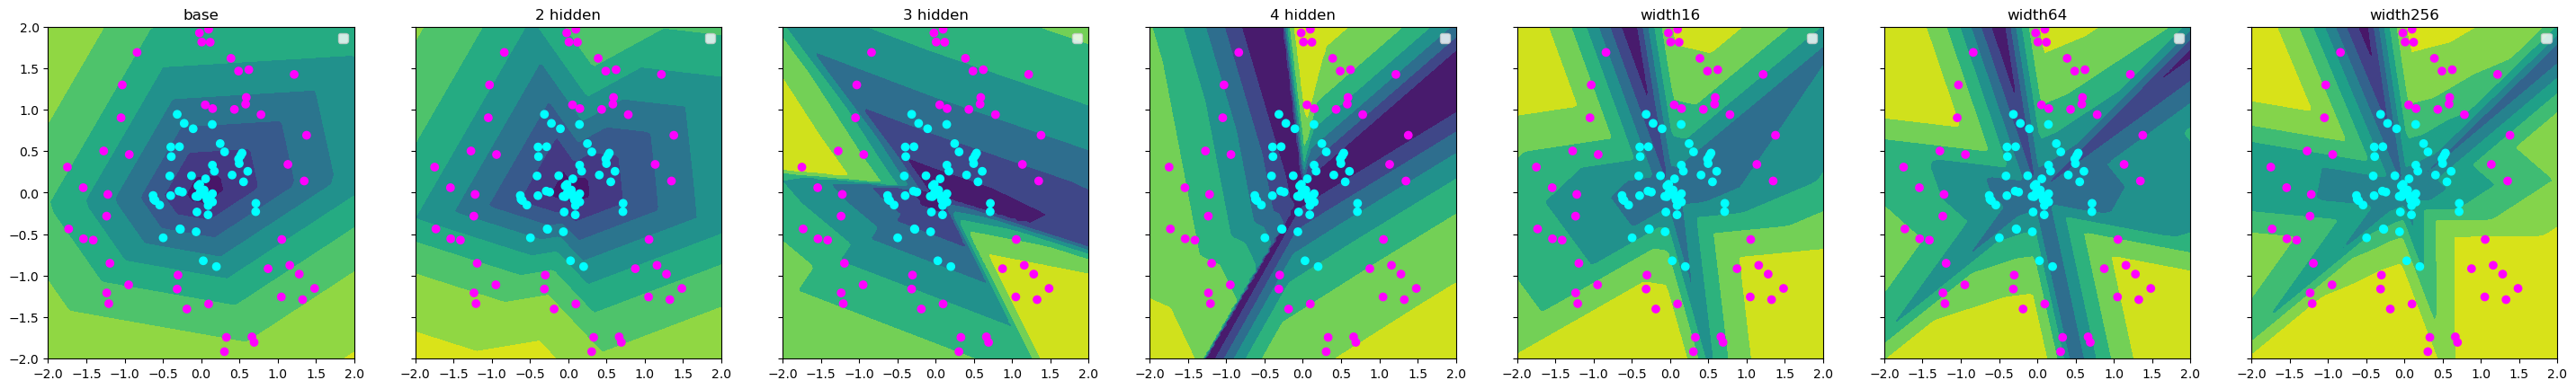

In [244]:
mesh = 100
x = np.linspace(-2,2,mesh,dtype=np.float64)
y = np.linspace(-2,2,mesh,dtype=np.float64)

X, Y = np.meshgrid(x, y)

Z = np.zeros((mesh,mesh))

fig,axs = plt.subplots(1,7,sharex=True,sharey=True)

fig.set_figwidth(36)

n = 0
for name, model in models.items():
    for i in range(mesh):
        for j in range(mesh):
            x1, x2 = X[i,j], Y[i,j]
            Z[i,j] = model(torch.Tensor([x1,x2]).double())

    axs[n].contourf(X, Y, Z, 7)
    axs[n].scatter(x_data[:,0],x_data[:,1],c=y_data,cmap="cool")
    axs[n].set_title(name)
    n += 1

In [209]:
Z

array([[0.71857302, 0.71552704, 0.71244515, ..., 0.40983186, 0.40876342,
        0.4076681 ],
       [0.71777877, 0.71472761, 0.71165672, ..., 0.41058878, 0.40949196,
        0.40839603],
       [0.71698317, 0.71392683, 0.71085081, ..., 0.4113183 , 0.41022088,
        0.4092149 ],
       ...,
       [0.75795139, 0.75428236, 0.75064614, ..., 0.51867482, 0.51641677,
        0.51415804],
       [0.75855709, 0.75496357, 0.75133411, ..., 0.52132475, 0.5190676 ,
        0.51680967],
       [0.75923023, 0.7556435 , 0.75199938, ..., 0.52395381, 0.52171736,
        0.51946035]])